# Hello and Welcome to the Ride of a Lifetime
This, my dear friends, will be the single most important thing that will ever happen to you ever. I am about to walk you through the most intricate code you have ever seen before. So buckle up, kiddo. We're on a highway to hell. \*cue music\* (https://www.youtube.com/watch?v=l482T0yNkeo&ab_channel=acdcVEVO)

## First, let's load some things

In [1]:
import os
import time
import glob
import re
from functools import reduce
import numpy as np
import uproot
import uproot_methods
import awkward
import pandas as pd
from klepto.archives import dir_archive


import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray

%matplotlib inline
import matplotlib.pyplot as plt



## Perfect, you're doing great sweaty.  Now, let's move on to the hard part. 
Now we are going to build a processor. A processor is very neat. In a processor, I can tell it to take some data, manipulate it in some way and save that manipulation into a histogram all without a for loop, yay! Let's get into it. 

In [2]:
#Let's define our processor first. 

class WHhadProcessor(processor.ProcessorABC):
    def __init__(self):
        
        #Great, now let's define some bins for our histograms.
        
        dataset_axis         = hist.Cat("dataset", "Primary dataset")
        pt_axis              = hist.Bin("pt", r"$p_{T}$ (GeV)", 500, 0, 2000)
        multiplicity_axis    = hist.Bin("multiplicity", r"N", 30, -0.5, 29.5)

        #In order to create proper histograms, we always need to include a dataset axis!
        #For different types of histograms with different scales, I create axis to fit 
        #those dimensions!
        
        #Now, let's move to actually telling our processor what histograms we want to make.
        #Let's start out simple. 
        self._accumulator = processor.dict_accumulator({
            "met":                          hist.Hist("Counts", dataset_axis, pt_axis),
            "ht":                           hist.Hist("Counts", dataset_axis, pt_axis),
            "njets":                        hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "bjets":                        hist.Hist("Counts", dataset_axis, multiplicity_axis),            
        })

    #Make sure to plug in the dataset axis and the properly binned axis you created above.
    #Cool. Now let's define some properties of the processor.
    
    @property
    
    #First is this guy. He does important things so always include him. 
    def accumulator(self):
        return self._accumulator

    #Now comes the fun part. Here's where we tell our processor exactly what to do with the data.
    def process(self, df):
     
        #Make sure to declare your output, which stores everything you put into the histograms.
        output = self.accumulator.identity()
        
        #Load your data for the dataset axis.
        dataset = df['dataset']

        #Let's define some variables from our dataset, starting with MET.
        metphi = df["MET_phi"]
        metpt = df["MET_pt"]
        #Here, I'm simply calling those nanoaod branches from the samples
        #and storing them under easy to access variable names. 
        
      
        
        #Let's define some 4 vector objects. For these I can call the branches whatever 
        #I want. Just make sure to include the .content at the end. Also, by making these
        #objects, we can call the branches in a pretty easy way. Shown below.
        
        #Leptons
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt=df['Electron_pt'].content, 
            eta=df['Electron_eta'].content, 
            phi=df['Electron_phi'].content,
            mass=df['Electron_mass'].content,
            pdgid=df['Electron_pdgId'].content,
            mini_iso=df['Electron_miniPFRelIso_all'].content
        )
        

        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'].content, 
            eta=df['Muon_eta'].content, 
            phi=df['Muon_phi'].content,
            mass=df['Muon_mass'].content,
            pdgid=df['Muon_pdgId'].content,
            mini_iso=df['Muon_miniPFRelIso_all'].content, 
            looseid =df['Muon_looseId'].content
        )
        
        taus = JaggedCandidateArray.candidatesfromcounts(
            df['nTau'],
            pt=df['Tau_pt'].content, 
            eta=df['Tau_eta'].content, 
            phi=df['Tau_phi'].content,
            mass=df['Tau_mass'].content,
            decaymode=df['Tau_idDecayMode'].content,
            newid=df['Tau_idMVAnewDM2017v2'].content,
        )
        
        #Here, since I don't have enough information to form a 4 vector with isotracks,
        #I just use the JaggedArray format. I call branches in the same way as the
        #JaggedCandidateArray, but I can't use some of the manipulations that come with the
        #JCA format. :(
        isotracks = awkward.JaggedArray.zip(
            pt=df['IsoTrack_pt'], 
            eta=df['IsoTrack_eta'], 
            phi=df['IsoTrack_phi'], 
            rel_iso=df['IsoTrack_pfRelIso03_all'], 
        )
        
        #Jets
        jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'].content, 
            eta=df['Jet_eta'].content, 
            phi=df['Jet_phi'].content,
            btag=df['Jet_btagDeepB'].content, 
            jetid=df['Jet_jetId'].content, 
            mass=df['Jet_mass'].content,
        )
        fatjets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'].content, 
            eta=df['FatJet_eta'].content, 
            phi=df['FatJet_phi'].content, 
            mass=df['FatJet_mass'].content, 
            softdrop=df["FatJet_msoftdrop"].content,  
            fromH = df['FatJet_deepTagMD_HbbvsQCD'].content, 
            fromW_MD = df['FatJet_deepTagMD_WvsQCD'].content, 
            fromW_MC = df['FatJet_deepTag_WvsQCD'].content
        )
        
        #Now let's deal with some good ol' ak4's baby. Let's define a "good jet".
        #First, let's define what a good jet should be. Notice how I'm calling the branches
        #of the jets. Super easy, right?
        goodjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0))
        #Perfect, now let's apply this selection to the ak4's and create a new object.
        goodjets = jets[goodjcut]
        #LIT. Okay, now I want the number of good jets. 
        njets = goodjets.counts
        #Bro, you are on fire. Good job. I'm proud of you and really appreciate you.

      

        #Let's make some b-jets and find the number of b-jets.
        bjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0) & (jets.btag>0.4184))
        bjets = jets[bjcut]
        nbjets = bjets.counts
        #Hell yeah. 
        
        #Let's go for HT now. 
        ht = goodjets.pt.sum()
        #Remember to put that () after the sum!

  
       
       
        #Let's define lepton vetos using the same method.
        
        veto_e_cut = (electrons.pt>5) & (abs(electrons.eta) < 2.4) & (electrons.mini_iso < 0.2)
        veto_e = electrons[veto_e_cut]
        
        veto_m_cut = (muons.pt > 5) & (abs(muons.eta) < 2.4) & (muons.looseid) & (muons.mini_iso < 0.2)
        veto_m = muons[veto_m_cut]
        
        veto_t_cut = (taus.pt > 20) & (abs(taus.eta) < 2.4) & (taus.decaymode) & (taus.newid >= 8)
        veto_t = taus[veto_t_cut]
        
        veto_it_cut = (isotracks.pt > 10) & (abs(isotracks.eta) < 2.4) & ((isotracks.rel_iso < (0.1*isotracks.pt)) | (isotracks.rel_iso < 6))
        veto_it = isotracks[veto_it_cut]
        
       
       
        #Now it's time to make some selections. I'm going to guess that you can follow
        #what I'm doing from here. 

        ht_ps = (ht > 300)
        met_ps = (metpt>400)
        njet_ps = (njets >= 2)
        bjet_ps = (nbjets >= 1)


        e_sel = (veto_e.counts == 0)
        m_sel = (veto_m.counts == 0)
        it_sel = (veto_it.counts == 0)
        t_sel = (veto_t.counts == 0)
        l_sel = e_sel & m_sel & it_sel & t_sel

        
        sel = ht_ps & met_ps & njet_ps & bjet_ps & l_sel 
      
    
        #Let's make sure we weight our events properly with the proper selection too.
        wght = df['weight'][sel]*137
 
        
        
        #Let's fill some histograms. 
        output['met'].fill(dataset=dataset, pt=metpt[sel].flatten(), weight=wght)
        output['ht'].fill(dataset=dataset, pt=ht[sel].flatten(), weight=wght)
        output['njets'].fill(dataset=dataset, multiplicity=njets[sel].flatten(), weight=wght)
        output['bjets'].fill(dataset=dataset, multiplicity=nbjets[sel].flatten(), weight=wght)        
        #Notice I have put .flatten() next to the data I'm inputting. This makes my
        #data arrays the appropriate format to input into histograms. 
        
        #Return that output, hunty!
        return output

    #Remember this bad boy and we're done with this block of code!
    
    def postprocess(self, accumulator):
        return accumulator
        

# Awesome! Now's it's smooth sailing from here. 
Let's put in some data now and run our processor! 

In [3]:
fileset   = {'mC750_l1': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/*.root'),
            'WJets': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WJetsToLNu*/*.root'),
            'QCD': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/QCD_HT*/*.root'),
            'TTJets': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/TTJets*/*.root'),
            'ZNuNu': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/ZJetsToNuNu*/*.root'),
            'ST':glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/ST*/*.root'),
            'ttW/ttZ':glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/ttWJets*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/ttZJets*/*.root'),
            'WW/WZ/ZZ':glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WW*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WZ*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/ZZTo2L2Nu*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/ZZTo2Q2Nu*/*.root')
                }

#Here, I've separated by data from my background. This lets me change the style of the
#signal line and keep the background consistent. 

output = processor.run_uproot_job(fileset,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )

#Here, we have the ability to change the 'workers' and 'chunksize', but to be honest,
#it does not make that much of a difference unless you want to see your progress bar 
#get updates more or less often. Totally a person choice. 

# Time to make some pretty ass histograms uwu!!

In [4]:
#Here's a block to help you make some pretty histos. This deals solely with style.
#These first two variables define my signal line as red and defines the error bar style I want!
lineopts = {
    'color': 'r',
}

data_err_opts = {
    'linestyle': 'none',
    'marker': '_',
    'markersize': 10.,
    'color': 'r',
    'elinewidth': 1,
}

#Now, let's go to background. I define the line and fill color for the background because
#I want it to be a different style from my signal. 

lineopts2 = {
    'color': [('#1467cc'), ('#51d673') ,('#f7d969'), ('#af84f0'), ('#4f842e'), ('#1ff4ff'),('#3612ab')],
}
fillopts1 = {
    'edgecolor': (0,0,0,0.3),
    'facecolor': [('#1467cc'), ('#51d673') ,('#f7d969'), ('#af84f0'), ('#4f842e'), ('#1ff4ff'),('#3612ab')],
}

#Here are two special functions I wrote to help you easily print histos to your output
#directory. All you need to input is the signal and background histograms, the output
#directory and the name of the histogram. 

def savefig(hists, outdir, name):
    import re
    bkgonly = re.compile('(?!mC750_l1)')
    ax = hist.plot1d(hists[bkgonly], overlay="dataset", density=False, stack=True, 
                fill_opts = fillopts1, overflow = 'over')
    hist.plot1d(hists['mC750_l1'], overlay="dataset", density=False, stack=False, 
                error_opts=data_err_opts, overflow = 'over') 
    ax.set_yscale('log')
    ax.set_ylim(0.001,1000000)
    ax.figure.savefig(os.path.join(outdir, "{}_log.png".format(name)))
    ax.clear()

def savefigshape(hists, outdir, name):
    ax = hist.plot1d(hists, overlay="dataset", density=True, stack=False, 
                line_opts = lineopts2, overflow = 'over')
    
    ax.set_yscale('log')
    ax.set_ylim(0.00001,10)
    ax.figure.savefig(os.path.join(outdir, "{}_shape_log.png".format(name)))
    ax.clear()

In [5]:
#Let's remind ourselves of the histograms we created so we can loop through them 
#and create an array to loop through when we rebin. 
histograms = ["met", "ht", "njets", "bjets"]

#Make sure this points to a directory you can print to!
outdir = "/home/users/mbryson/public_html/dump/WH/"

met
ht
njets
bjets


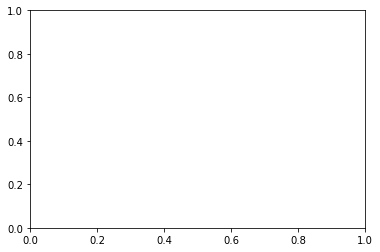

In [6]:
#Let's loop through these histograms and rebin! Remember to change the binning for both the
#signal and background!!! Here I can also change the title of my plots!!
for name in histograms:
    print (name)
    hists = output[name]
    
    if name == "met":
        new_met_bins = hist.Bin('pt', r'MET', 26, 248, 1600)
        hists = hists.rebin('pt', new_met_bins)
        
    if name == "ht":
        new_ht_bins = hist.Bin('pt', r'HT', 25, 300, 2000)
        hists = hists.rebin('pt', new_ht_bins)
        
    if name == "njets":
        new_nj_bins = hist.Bin('multiplicity', r'nJets', 16, -0.5, 15.5)
        hists = hists.rebin('multiplicity', new_nj_bins)
        
    if name == "bjets":
        new_bj_bins = hist.Bin('multiplicity', r'nBJets', 7, -0.5, 6.5)
        hists = hists.rebin('multiplicity', new_bj_bins)
        
    savefig(hists,outdir, name)
    savefigshape(hists,outdir, name)
#In these last two lines, I call those special histogram functions I made! Check your
#output directory once this is done and all your pretty plots will be there!